##### Expand View


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [2]:
# Exploring MNIST Gans

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST  # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_01')

import matplotlib.pyplot as plt
# import wandb

from markipy.nn.gans.generatorMark import get_gen_loss, Generator
from markipy.nn.gans.discriminator import get_disc_loss, Discriminator
from markipy.nn.commons import show_tensor_images, make_noise
from markipy.basic import date


torch.manual_seed(0)  # Set for testing purposes, please do not change!

PROJECT="MNIST"
VERSIONE="0.31"
RUN="3"

# default `log_dir` is "runs" - we'll be more specific here\
logs=f'runs/{PROJECT}_{VERSIONE}.{date()}#{RUN}'

writer = SummaryWriter(logs)
print(f"Logs at: {logs}")


Logs at: runs/MNIST_0.31.2020.10.26#2


## Hyperparameters

In [3]:
    # Mnist Playground
    device = torch.device('cpu')
    n_epochs = 1
    noise_c = 1 
    noise_w = noise_b = 28
    z_dim = (noise_c, noise_w, noise_b)
    display_step = 468
    log_step = 10
    batch_size = 32
    lr = 0.00001
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    test_generator = False  # Whether the generator should be tested
    gen_loss = False
    error = False

## Load Data

In [4]:
    # Load MNIST dataset as tensors
    dataloader = DataLoader(
        MNIST('.', download=True, transform=transforms.ToTensor()),
        batch_size=batch_size,
        shuffle=True)

## Core

In [5]:
    criterion = nn.BCEWithLogitsLoss()
    gen = Generator(noise_c, device=device).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

# Generator Details

In [6]:
from pytorch_model_summary import summary
n_sample = 1
noise_input = make_noise( n_sample, (noise_c, noise_w, noise_b), device=device)

print(summary(gen, noise_input,  show_input=True))
print(summary(gen, noise_input,  show_input=False))

---------------------------------------------------------------------------------------------
      Layer (type)                               Input Shape         Param #     Tr. Param #
        Upsample-1                            [1, 1, 28, 28]               0               0
          Conv2d-2                            [1, 1, 33, 33]             130             130
     BatchNorm2d-3                            [1, 5, 33, 33]              10              10
       LeakyReLU-4                            [1, 5, 33, 33]               0               0
         Flatten-5                            [1, 5, 33, 33]               0               0
            LSTM-6     [5, 1, 400], [2, 1, 400], [2, 1, 400]       2,566,400       2,566,400
       AvgPool2d-7                               [1, 5, 800]               0               0
          Conv2d-8                            [1, 2, 20, 20]              51              51
     BatchNorm2d-9                            [1, 1, 24, 24]         

# Discriminator Details

In [7]:
from pytorch_model_summary import summary
n_sample = 1
_input = make_noise( n_sample, ( 1, 28 * 28), device=device)

print(summary(disc, _input,  show_input=True))
print(summary(disc, _input,  show_input=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 28, 28]             260             260
       LeakyReLU-2     [1, 10, 28, 28]               0               0
       MaxPool2d-3     [1, 10, 28, 28]               0               0
          Conv2d-4     [1, 10, 26, 26]           5,020           5,020
       LeakyReLU-5     [1, 20, 26, 26]               0               0
       MaxPool2d-6     [1, 20, 26, 26]               0               0
          Conv2d-7     [1, 20, 24, 24]          15,030          15,030
       LeakyReLU-8     [1, 30, 24, 24]               0               0
       MaxPool2d-9     [1, 30, 24, 24]               0               0
         Conv2d-10     [1, 30, 22, 22]           1,502           1,502
      LeakyReLU-11      [1, 2, 22, 22]               0               0
      MaxPool2d-12      [1, 2, 22, 22]               0               0
     

## View Input Data

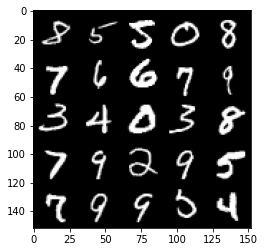

torch.Size([32, 1, 28, 28]) torch.Size([32]) tensor([8, 5, 5, 0, 8, 7, 6, 6, 7, 9, 3, 4, 0, 3, 8, 7, 9, 2, 9, 5, 7, 9, 9, 5,
        4])


In [8]:
for x,y in dataloader:
    show_tensor_images(x, num_images=25)
    print(x.shape, y.shape, y[:25])
    break
    

# Train - 1 Step

In [9]:
disc_init = False
n_epochs = 1 
for epoch in range(n_epochs):
    
    # Dataloader returns the batches
    bar = tqdm(dataloader)
    for real, label in bar:
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        if cur_step % 300: 
            ### Update discriminator ###
            # Zero out the gradients before backpropagation
            disc_opt.zero_grad()

            # Calculate discriminator loss
            disc_loss = get_disc_loss(gen, disc, criterion, real, label, cur_batch_size, z_dim, device)

            # Update gradients
            disc_loss.backward(retain_graph=True)

            # Update optimizer
            disc_opt.step()
            
            disc_init = True

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Update gradients
        gen_opt.zero_grad()

        # Update optimizer
        gen_loss = get_gen_loss(gen, disc, criterion, label, cur_batch_size, z_dim, device)

        # Update gradients
        gen_loss.backward(retain_graph=True)

        # Update optimizer
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
                
            except:
                error = True
                
                # wandb.log({"no_training": 1, "epoch": epoch, "loss": loss})
                print("Runtime tests have failed")

        if disc_init:
            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:


            noise = make_noise(cur_batch_size, z_dim, device=device)
            fake = gen(noise)
            
            show_tensor_images(fake)
            show_tensor_images(real)
            
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            

        
        if cur_step % log_step == 0 and log_step > 0:
            # wandb.log({ "Epoch" : epoch, "step": cur_step , "Generator_Loss" : mean_generator_loss, "Discriminator_Loss": mean_discriminator_loss })
            bar.set_description(f"Epoch {epoch}, step {cur_step}: GenL: {mean_generator_loss if disc_init else 'nan'}, DisL: {mean_discriminator_loss}")
            # Tensorboard
            writer.add_scalar('mean_generator loss', mean_generator_loss, cur_step)
            writer.add_scalar('mean_discriminator_loss loss', mean_discriminator_loss, cur_step)
        
        # Increase step
        cur_step += 1
    
        
        
# Shift + o  : To show scroll the ouput 

Epoch 0, step 0: GenL: nan, DisL: 0:   0%|          | 1/1875 [00:00<08:52,  3.52it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "C:\Users\marco\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-41c5f3c34c5c>", line 37, in <module>
    gen_loss = get_gen_loss(gen, disc, criterion, label, cur_batch_size, z_dim, device)
  File "C:\Users\marco\miniconda3\lib\site-packages\markipy\nn\gans\generatorMark.py", line 115, in get_gen_loss
    x_gen = gen(noise)
  File "C:\Users\marco\miniconda3\lib\site-packages\torch\nn\modules\module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "C:\Users\marco\miniconda3\lib\site-packages\markipy\nn\gans\generatorMark.py", line 78, in forward
    X = F.leaky_relu(self.cv2(X), 0.1)
  File "C:\Users\marco\minic

TypeError: object of type 'NoneType' has no len()

In [ ]:

def log_image_board(writer, images, label):
    # create grid of images
    img_grid = torchvision.utils.make_grid(images)

    # show images
    show_tensor_images(img_grid, show=False)

    # write to tensorboard
    writer.add_image(label, img_grid)

log_image_board(writer,fake, 'fake_0')


In [11]:
real = real.reshape(real.shape[0], 1, 28, 28)
real.shape

torch.Size([32, 1, 28, 28])

In [12]:
from markipy.nn.commons import get_conv2d_block
cv1 = get_conv2d_block(1, 5, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out1 = cv1(real)
out1.shape


torch.Size([32, 5, 28, 28])

In [13]:
cv2 = get_conv2d_block(5, 10, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out2 = cv2(out1)
m2 = nn.MaxPool2d((3, 3), stride=(1, 1))
out2 = m2(out2)
out2.shape

torch.Size([32, 10, 26, 26])

In [14]:
cv3 = get_conv2d_block(10, 20, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out3 = cv3(out2)
m3 = nn.MaxPool2d((3, 3), stride=(1, 1))
out3 = m2(out3)
out3.shape

torch.Size([32, 20, 24, 24])

In [15]:
cv4 = get_conv2d_block(20, 10, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out4 = cv4(out3)
m4 = nn.MaxPool2d((3, 3), stride=(1, 1))
out4 = m4(out4)
out4.shape

torch.Size([32, 10, 22, 22])

In [16]:
cv5 = get_conv2d_block(10, 2, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out5 = cv5(out4)
m5 = nn.MaxPool2d((3, 3), stride=(1, 1))
out5 = m5(out5)
out5.shape

torch.Size([32, 2, 20, 20])

In [21]:


from markipy.nn.commons import get_conv2d_block
oc = 5

n_sampled = x.shape[0]

cv1 = get_conv2d_block(1, oc, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
m = nn.Upsample(scale_factor=1.2, mode='bilinear').cuda()
f = nn.Flatten(2).cuda()

x = real        ;print('Input  \t\t', x.shape)
x = m(x)        ;print('Upsampled  \t\t', x.shape)
x = cv1(x)      ;print('Conv2d  \t\t', x.shape)
x = f(x)        ;print('Flatten  \t\t', x.shape)


Ln = [nn.Linear(1089, 800) for n in range(oc)]
Xn = torch.zeros(n_sample, oc, 800) # Pilars


for xi in range(oc):
    
    Xn[:xi] = Ln[xi](x[:,:1].view(n_sampled,1089))         ; print(f'Linear {xi + 1} \t\t', Xn[xi])






RuntimeError: CUDA error: an illegal memory access was encountered

In [56]:
f = nn.Flatten(2)


In [59]:
f(t2).shape

torch.Size([32, 5, 1089])

In [69]:
x.shape

torch.Size([32, 5, 1089])

In [78]:
x[:1,:1].shape



torch.Size([1, 1, 1089])

In [81]:
torch.zero_like(x[0:1,]).shape

torch.Size([1, 1, 1089])

In [92]:
x[:,:1].shape

torch.Size([32, 1, 1089])

In [84]:
x[:1,:1].reshape(1089)

tensor([0.1788, 0.1788, 0.1788,  ..., 0.1788, 0.1788, 0.1788], device='cuda:0',
       grad_fn=<ViewBackward>)

In [99]:
x[:,:1].view(n_sampled,1089).shape

torch.Size([32, 1089])

In [20]:
t = torch.zeros(5,800)
t[:1].shape

torch.Size([1, 800])